### Load Data

In [653]:
import numpy as np

name, K = "Datasets/Aggregation.txt", 7
# name, K = "Datasets/D31.txt", 31
# name, K = "Datasets/R15.txt", 15
X= np.loadtxt(name)
m = X.shape[0]
X.shape

(788, 2)

### Calculate Distance Matrix

In [654]:
def calc_dist_matrix(X: np.ndarray) -> np.ndarray:
    prod = X @ X.transpose()
    self_prod = np.diagonal(prod, axis1=0, axis2=1)
    return np.sqrt(-2 * prod + self_prod + self_prod[:, np.newaxis])


D = calc_dist_matrix(X)
D.shape

(788, 788)

### Calc $\rho$ and $\delta$

In [655]:
# Using 1-2% quantile as d_c
def calc_dc(D: np.ndarray, rate=0.02):
    allD = D[np.triu_indices(m, 1)]
    return np.quantile(allD, rate), np.max(allD), np.min(allD)


dc, maxd, mind = calc_dc(D)
dc, maxd, mind

(1.8601075237738232, 38.81546083714581, 0.11180339887493865)

In [656]:
def calc_rho(D: np.ndarray, dc: np.float64, method="gaussian") -> np.ndarray:
    if method == "gaussian":
        return np.sum(np.exp(-((D / dc) ** 2)), axis=-1) - 1
    else:
        return np.sum(D < dc, axis=-1) - 1  # exclude self


rho = calc_rho(D, dc)
rho[:10]

array([ 3.18135683,  5.47687217,  7.05878561,  6.98294232,  9.67023154,
        9.85644021,  7.56009576, 10.77722227,  8.75625192, 12.44131178])

In [657]:
def calc_delta(D: np.ndarray, rho: np.ndarray):
    delta = np.zeros(rho.shape)
    neigh = np.zeros(rho.shape, dtype=int)
    for i in range(m):
        j_list = np.where(rho > rho[i])[0]
        if len(j_list):
            delta[i] = np.min(D[i][j_list])
            neigh[i] = j_list[np.argmin(D[i][j_list])]
        else:
            delta[i] = np.max(D[i])
    return delta, neigh

delta, neigh = calc_delta(D, rho)
delta[:5], neigh[:5]

(array([1.14017543, 0.91787799, 0.76157731, 0.54083269, 0.56568542]),
 array([2, 2, 4, 2, 5]))

### Plot Decision Graph

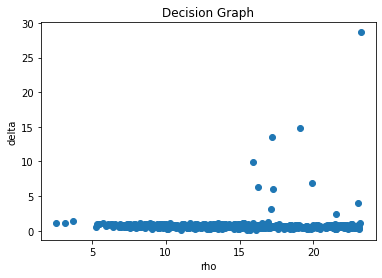

In [658]:
def plot_decision_graph(delta: np.ndarray, rho: np.ndarray):
    import matplotlib.pyplot as plt
    fig = plt.figure()
    ax1 = fig.add_subplot()
    # Setting graph title
    ax1.set_title('Decision Graph')
    # Setting label for x-axis
    plt.xlabel('rho')
    # Setting label for y-axis
    plt.ylabel('delta')
    # Plot the scatter graph
    ax1.scatter(rho, delta)
    # Show the graph
    plt.show()

plot_decision_graph(delta=delta, rho=rho)

### Select Cluster Centers

In [659]:
def select_centers(rho: np.ndarray, delta: np.ndarray, K: int):
    return np.argsort(-rho * delta)[:K]


centers = select_centers(rho, delta, K)
centers

array([319, 613,  59, 723, 768, 190, 555], dtype=int64)

In [660]:
def choose_cluster(neigh: np.ndarray, centers: np.ndarray, rho: np.ndarray):
    cluster = np.array([-1] * m)
    for c, i in enumerate(centers):
        cluster[i] = c
    for i in np.argsort(-rho):
        if cluster[i] == -1:
            cluster[i] = cluster[neigh[i]]
    return cluster

cluster = choose_cluster(neigh, centers, rho)
cluster[:5]

array([2, 2, 2, 2, 2])

### Evaluation Metrics

In [661]:
import sklearn.metrics

sklearn.metrics.davies_bouldin_score(X, cluster)

0.5035680502991704

### Draw Visualization Graph

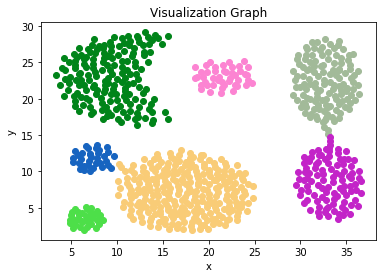

In [662]:
def plot_visualization_graph(X: np.ndarray, cluster: np.ndarray):
    import matplotlib.pyplot as plt
    fig = plt.figure()
    ax1 = fig.add_subplot()
    ax1.set_title("Visualization Graph")
    plt.xlabel("x")
    plt.ylabel("y")
    c = cluster.shape[0]
    for i in range(c):
        idxs = np.where(cluster == i)
        pnts = X[idxs]
        ax1.scatter(pnts[:, 0], pnts[:, 1], color=np.random.rand(3))
    # Show the graph
    plt.show()


plot_visualization_graph(X, cluster)